In this notebook, I will use torch_geometric to predict the developpement of a graph of positions through time

In [1]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

import numpy as np

import torch_geometric
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import radius_graph
from torch_geometric.data import Data

import networkx as nx

import pickle

import time

import sys
import os
from genericpath import exists

import random

model_path = "model.pkl"
loss_path = "loss.pkl"

from cell_dataset import CellGraphDataset
from cell_model import GraphEvolution
from cell_utils import GraphingLoss
from cell_training import train, test, run_single

import threading
import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())


sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
import allium

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using :  297
Available :  3277
True


The data is a graph of cells having their own positions and velocity.

In the graph, we will first start by connecting all the edges, then maybe later make radius_graphs to reduce the cost of the pass through the model

In [2]:
#path = "data/" #local
path = "/scratch/users/nstillman/data-cpp/" #remote

data_train = CellGraphDataset(root=path + 'train', max_size=200, rdts=True, inmemory=True, bg_load=True)
print("Training data length : ", data_train.len())

data_test = CellGraphDataset(root=path + 'test', max_size=50, inmemory=True, bg_load=True)
print("Test data length : ", data_test.len())
 
data_val = CellGraphDataset(root=path + 'valid', max_size=50, inmemory=True, bg_load=True)
print("Validation data length : ", data_val.len())

Training data length :  200
Test data length :  50
Validation data length :  50


In [3]:
 
override = True #make this true to always use the same ones


In [4]:
rval, edge_index, edge_attr, batch_edge = data_train.get(0)
#print(rval, edge_index, edges_attr, batch_edge)

Next we need to define the model that will be used :
    > input 
        (1) Graph at a particular time t (nodes having x,y,dx,dy as attributes)
        (2) Graphs up to a particular time [t-a, t] (nodes having x,y as attributes)
    > output
        (a) Graph at the immediate next time step t+1
        (b) Graph [t, t+b]
        (c) Graph at t+b
    > graph size
        (x) Fixed graph size to the most nodes possible (or above)
        (y) Unbounded graph size
            >> idea : graph walks
            >> idea : sampler

The following model will do (1ax)

In [5]:
global losses
losses = []

In [14]:
def start(model, optimizer, scheduler, data_train, data_test, device, epoch, offset, save=0, early_stop=False):
    for e in range(offset, offset + epoch):
        model = train(model, optimizer, scheduler, data_train, device, e, process)
            
        test_loss = test(model, data_test, device)
        
        print("Epoch : ", e, "Test loss : ", test_loss, "                                                         ")
        
        losses.append(test_loss)
        
        if early_stop and len(losses) > 30 :
            recent_losses = min(len(losses), 30)
            y = losses[-recent_losses:]
            
            axis = np.arange(recent_losses)
            A = np.vstack([axis, np.ones(len(axis))]).T
            
            a = np.linalg.lstsq(A, y, rcond=None)
            
            if a[0][0] >= -0.002 :
                print("Early stopping : recent slope at ", a[0][0])
                if (save) :
                    with open(model_path, 'wb') as f:
                        pickle.dump(model, f)
                return
            else : 
                print("Early stopping passed : current slope at ", a[0][0])
        
        if (save and (e%save == 0 or e == epoch-1)) :
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            with open(loss_path, 'wb') as f:
                pickle.dump(losses, f)

In [9]:
load = True
if (load and exists(model_path)) :
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(loss_path, 'rb') as f:
        losses = pickle.load(f)
else :
    model = GraphEvolution(4, 4, 32, 8, 0.0, edge_dim=len(data_train.attributes));
    
assert isinstance(model, GraphEvolution)
    
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2)

Epoch :  501 Test loss :  1.6410113921761513                                                                
Epoch :  502 Test loss :  1.6303067715466022                                                               
Epoch :  503 Test loss :  1.6345515128970147                                                                
Epoch :  504 Test loss :  1.6393278269469738                                                                
Epoch :  505 Test loss :  1.6319661018252374                                                               
Epoch :  506 Test loss :  1.6234690676629544                                                               
Epoch :  507 Test loss :  1.6036989143490792                                                               
Epoch :  508 Test loss :  1.6176071894168853                                                                
Epoch :  509 Test loss :  1.6734341506659984                                                               
Epoch :  510 Test loss :

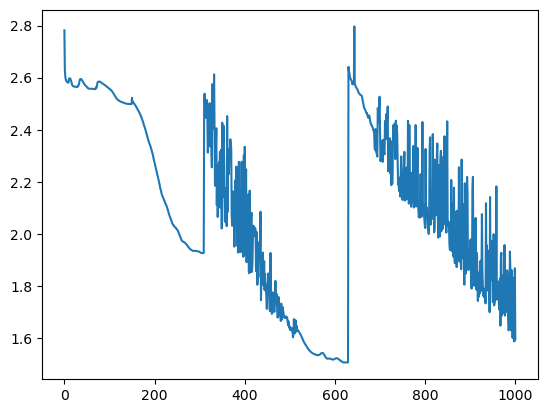

In [15]:
epochs = 501
grapher = GraphingLoss(losses)
scheduler.step(len(losses))
try :
    grapher.gstart(20)
    start(model, optimizer, scheduler, data_train, data_test, "cuda" if torch.cuda.is_available() else "cpu", epochs, len(losses), save=50, early_stop = False)
finally :
    grapher.gstop()

In [17]:
#things to do :
    #normalize the inputs 
    #make sure this model doesn't use past times (normally should not since the graph is disconnected and it's based on message passing)
    #show the results

In [32]:
#extract a single graph and the prediction
with open("model_601.pkl", "rb") as f:
    model = pickle.load(f)
    
loss, out, x = run_single(model, data_test, 0, "cuda" if torch.cuda.is_available() else "cpu")

In [33]:
with open("result_601.pkl", "wb") as f:
    pickle.dump((out, x), f)

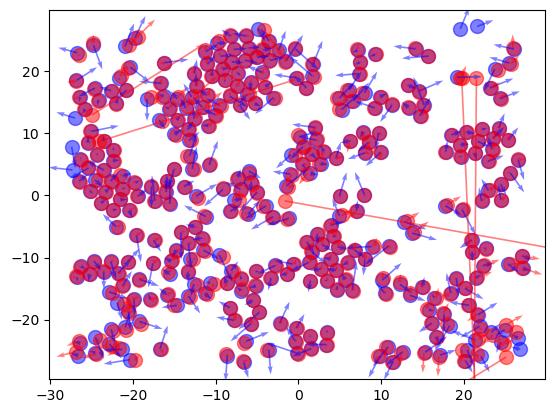

In [34]:
t = 30

pos_out = out[t, :, :2]
pos_x = x[t, :, :2]

speed_out = out[t, :, 2:]
speed_x = x[t, :, 2:]

#now plot the graph as bubbles to show the difference between the two
plt.scatter(pos_x[:, 0], pos_x[:, 1], s=100, c='b', alpha=0.5)
plt.scatter(pos_out[:, 0], pos_out[:, 1], s=100, c='r', alpha=0.5)

#show an arrow for the speed
plt.quiver(pos_x[:, 0], pos_x[:, 1], speed_x[:, 0], speed_x[:, 1], color='b', alpha=0.5)
plt.quiver(pos_out[:, 0], pos_out[:, 1], speed_out[:, 0], speed_out[:, 1], color='r', alpha=0.5)

In [10]:
#need ffmpeg to run the following

from matplotlib.animation import FuncAnimation
from IPython import display

with open("result_601.pkl", "rb") as f:
    out, x = pickle.load(f)

figure = plt.figure()
ax = figure.add_subplot(111)

left = -1 + x[:,:,0].min()
right = 1 + x[:,:,0].max()
down = -1 + x[:,:,1].min()
up = 1 + x[:,:,1].max()

def AnimationFunction(i):
    ax.clear()
    
    pos_out = out[i, :, :2]
    pos_x = x[i, :, :2]

    speed_out = out[i, :, 2:]
    speed_x = x[i, :, 2:]

    #now plot the graph as bubbles to show the difference between the two
    ax.scatter(pos_x[:, 0], pos_x[:, 1], s=100, c='b', alpha=0.5, label="True position")
    ax.scatter(pos_out[:, 0], pos_out[:, 1], s=100, c='r', alpha=0.5, label="Predicted position")

    #show an arrow for the speed
    ax.quiver(pos_x[:, 0], pos_x[:, 1], speed_x[:, 0], speed_x[:, 1], color='b', alpha=0.5, label="True speed")
    ax.quiver(pos_out[:, 0], pos_out[:, 1], speed_out[:, 0], speed_out[:, 1], color='r', alpha=0.5, label="Predicted speed")
    
    ax.set_xlim(left, right)
    ax.set_ylim(down, up)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    ax.set_title("Cell movement (position and speed) at time " + str(i) + " (out of " + str(x.shape[0]) + ")")

    ax.legend(["True position", "Predicted position"], loc="upper left")

anim_created = FuncAnimation(figure, AnimationFunction, frames=x.shape[0], interval=100)

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()